<a href="https://colab.research.google.com/github/SarathKasturi16/Reading-Assistant-System/blob/main/Reading_Asisstant_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Reader-Based Question Answering System**
##Architecture, Process, and Design Overview

#**(i)Project Objective**

The objective of this project is to design and implement a reader-based extractive Question Answering system that can accurately answer user questions strictly from a given context, while maintaining transparency, linguistic correctness, and explainability.

The system is designed as a reading assistant, enabling users to:

* Understand long passages through summarization

* Ask multiple questions about the same context

* Receive precise answers with confidence scores

* View supporting evidence directly from the text

* No external knowledge bases, retrieval systems, or training procedures are involved.

#**(ii)System Scope and Constraints**

1. Answers are extracted only from the provided context

2. Pretrained Transformer models are used only for inference

3. No model training or fine-tuning is performed

4. If an answer is not explicitly stated, it is clearly reported

#**(iii)Models Used**
1. **Question Answering Models (Extractive)**

   The system uses an ensemble of pretrained extractive QA models fine-tuned on SQuAD-style datasets:

* RoBERTa-based model (deepset/roberta-base-squad2)
Provides strong contextual understanding and robust answer extraction.

* BERT-based lightweight model (mrm8488/bert-tiny-finetuned-squadv2)
Offers faster inference while contributing complementary predictions.

2. **Summarization Model**

* BART-based summarization model (facebook/bart-large-cnn)

   This model generates concise summaries of long contexts to improve user readability.Summaries are displayed only for reference and are not used in the QA process.

3. **Linguistic Validation Model**

* spaCy POS tagger (en_core_web_sm)

   This model performs Part-of-Speech tagging on extracted answers to support linguistic validation.It is used to distinguish entity-level answers from purely descriptive phrases.




#System Architecture
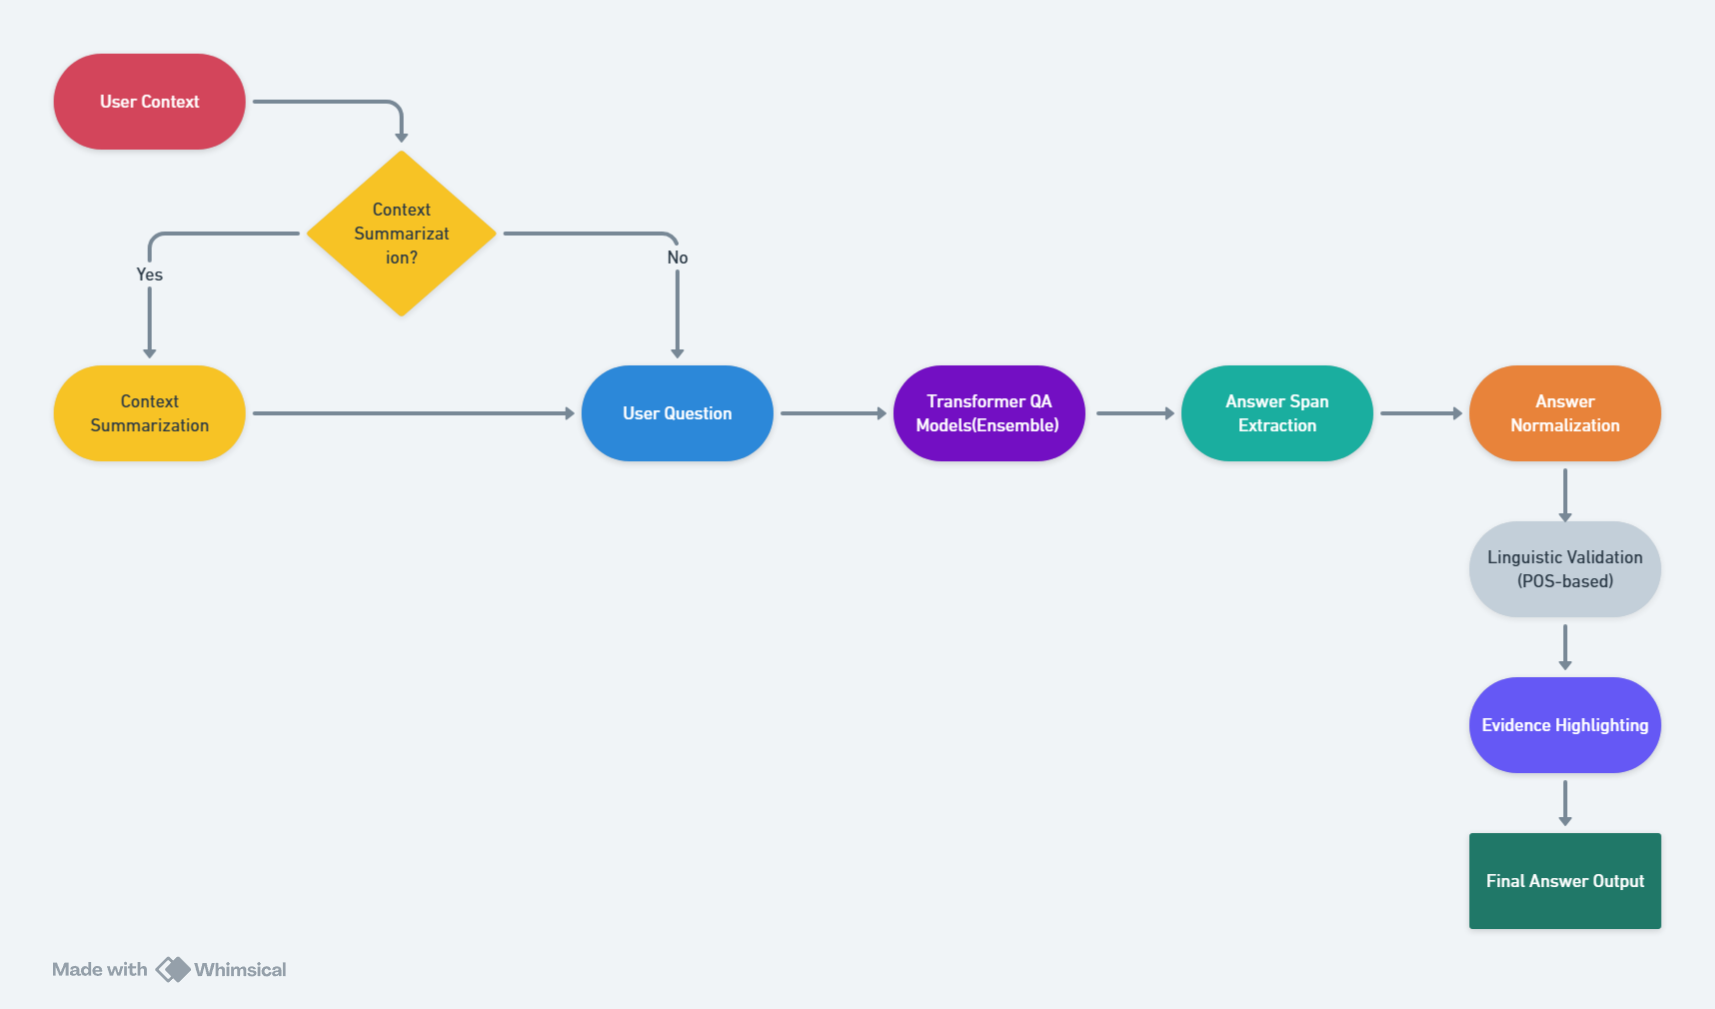

#**0.Install Required Libraries**

In [ ]:
!pip install transformers torch spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 83.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


The dependencies include:

1. transformers for pretrained Transformer models

2. torch as the underlying deep learning framework

3. spacy for linguistic analysis

#**1.Import Libraries**

In [ ]:
import torch
import re
import warnings
from collections import Counter
from transformers import pipeline, AutoTokenizer
import spacy

1. torch for hardware acceleration checks

2. re for text normalization

3. warnings to suppress non-critical logs

4. Counter for ensemble voting

5. pipeline and AutoTokenizer for Transformer inference

6. spacy for part-of-speech tagging


#**2.GPU/CPU Device Configuration**

In [ ]:
device = 0 if torch.cuda.is_available() else -1
print("Using device:", "GPU" if device == 0 else "CPU")

Using device: GPU


#**3.QA Models Configuration**

In [ ]:
QA_MODELS = [
    ("deepset/roberta-base-squad2", "roberta"),
    ("mrm8488/bert-tiny-finetuned-squadv2", "bert-tiny"),
]
nlp = spacy.load("en_core_web_sm")

This block loads all pretrained models required by the system.

Two categories of models are initialized:

1. Question Answering models (RoBERTa and BERT-based)

2. A linguistic POS tagger for validation

The QA models form an ensemble, improving robustness by aggregating predictions.
The spaCy model is used strictly for linguistic analysis and does not influence answer generation.

#**4.Creating pipelines for QA Models**

In [ ]:
qa_pipelines = []

for model_name, model_tag in QA_MODELS:
    qa = pipeline(
        "question-answering",
        model=model_name,
        tokenizer=AutoTokenizer.from_pretrained(model_name),
        device=device,
    )
    qa_pipelines.append((qa, model_tag))
    print(f"Loaded QA model: {model_name}")

if not qa_pipelines:
    raise RuntimeError("No QA models loaded.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

Device set to use cuda:0


Loaded QA model: deepset/roberta-base-squad2


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Some weights of the model checkpoint at mrm8488/bert-tiny-finetuned-squadv2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Loaded QA model: mrm8488/bert-tiny-finetuned-squadv2


This block initializes the Question Answering pipelines required by the system.

The following steps are performed:

1. Each pretrained Question Answering model is loaded as an inference pipeline.

2. A consistent execution device (CPU or GPU) is assigned to all pipelines.

3. The initialized pipelines are stored for ensemble-based answer extraction.

4. A safety check ensures that at least one QA pipeline is available before execution.

This setup enables reliable and consistent extractive question answering across multiple models.

#**5.Load Summarization Model**

In [ ]:
warnings.filterwarnings("ignore")

summary_pipeline = pipeline(
    "summarization", model="facebook/bart-large-cnn", device=device
)

print("Loaded summarization model")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Loaded summarization model


This block initializes the summarization component of the system.

The following elements are configured:

1. A pretrained Transformer-based summarization model (facebook/bart-large-cnn) is loaded.

2. The model is used to generate concise summaries of long input contexts.

3. The summarization process is executed on the selected device (CPU or GPU).

The summarization model is used solely for user understanding and does not participate in answer extraction or validation.

#**6.Answer Cleaning Utility**

In [ ]:
def clean_answer(answer):
    answer = re.sub(r"\s+", " ", answer).strip()
    answer = re.sub(r"##", "", answer)
    return answer

Utility function for cleaning extracted answer spans.

The function performs the following steps:

* Normalizes whitespace to ensure consistent formatting.

* Removes tokenization artifacts introduced by subword-based models.

* Trims leading and trailing spaces for readability.

#**7.Tightening Answer**

In [ ]:
def tighten_answer(answer, question):
    q = question.lower()

    if q.startswith(("identify", "which", "what")):
        answer = re.sub(r"^(the|a|an)\s+", "", answer, flags=re.IGNORECASE)

        for splitter in [" is ", " that ", " which ", " who "]:
            if splitter in answer.lower():
                answer = answer.split(splitter)[0].strip()

    return answer

This block defines a function to normalize extracted answer spans for identification-style questions.

The function applies the following steps:

1. Identifies questions that typically expect concise entity answers (e.g., identify, which, what).

2. Removes leading determiners such as the, a, and an from the answer span.

3. Truncates explanatory phrases to retain only the core entity.

4. Returns a concise and readable answer without altering its meaning.

This normalization step improves answer precision while preserving the model’s original prediction.

#**8.Descriptive Word Detection**

In [ ]:
def is_descriptive_answer(answer):
    doc = nlp(answer)
    noun_count = sum(1 for t in doc if t.pos_ in ("NOUN", "PROPN"))
    adj_count = sum(1 for t in doc if t.pos_ == "ADJ")

    return noun_count == 0 and adj_count > 0

This block defines a function to identify purely descriptive answers using linguistic analysis.

The function performs the following checks:

1. Applies Part-of-Speech (POS) tagging to the extracted answer.

2. Counts noun and proper noun tokens to detect entity-level information.

3. Counts adjective tokens to detect descriptive content.

4.Flags the answer as descriptive if it contains adjectives but no nouns.

This validation helps prevent adjective-only responses for entity-based questions, ensuring that accepted answers represent explicit entities rather than characteristics.

#**9.Answer Validation**

In [ ]:
def validate_answer(question, answer, context, score):
    if score < 0.1:
        return False
    if not answer:
        return False
    if len(answer.split()) > 20:
        return False
    if answer.lower() not in context.lower():
        return False

    if question.lower().startswith(("which", "what", "who")):
        if is_descriptive_answer(answer):
            return False

    return True

The validation ensures that:

* The model confidence is above a minimum threshold.

* The answer is non-empty, concise, and present in the given context.

* The answer is linguistically suitable for the type of question asked.

This step prevents low-confidence, overly long, or purely descriptive responses and ensures that only reliable, context-grounded answers are returned.

#**10.Evidence Extraction from Context**

In [ ]:
def extract_evidence(answer, context, max_chars=220):
    sentences = re.split(r"(?<=[.!?])\s+", context)
    for sent in sentences:
        if answer.lower() in sent.lower():
            sent = sent.strip()
            if len(sent) > max_chars:
                return sent[:max_chars].rsplit(" ", 1)[0] + "..."
            return sent
    return "Relevant evidence sentence not found."

This block extracts a supporting evidence sentence from the context.

The function identifies the sentence that contains the extracted answer and returns it as supporting evidence. If the sentence is too long, it is truncated for readability.

#**11.Context Summarization**

In [ ]:
def summarize_context(context):
    if len(context.split()) < 60:
        return "Context is short; summary not required."

    summary = summary_pipeline(context, max_length=120, min_length=40, do_sample=False)[
        0
    ]["summary_text"]

    return summary

* Determines whether the provided context is sufficiently long to benefit from summarization.

* Avoids summarization for short contexts to preserve efficiency and prevent unnecessary abstraction.

* Applies a pretrained Transformer-based summarization model to generate a concise overview of longer passages.

* Controls the summary length to maintain clarity and readability.

* Uses the summary exclusively as a user aid, without influencing the question answering pipeline.

#**12.Core Extractive Question Answering Pipeline**

In [ ]:
def reader_qa(question, context):
    answers = []

    for qa, tag in qa_pipelines:
        try:
            result = qa(
                question=question,
                context=context,
                handle_impossible_answer=True,
                max_answer_len=50,
                max_seq_len=512
            )

            if result["answer"].strip():
                answers.append({
                    "answer": clean_answer(result["answer"]),
                    "score": result["score"]
                })
        except:
            continue

    if not answers:
        return {
            "status": "REJECTED",
            "reason": "No answer could be extracted from the context"
        }

    best_answer = Counter(a["answer"] for a in answers).most_common(1)[0][0]
    best_answer = tighten_answer(best_answer, question)

    scores = [a["score"] for a in answers if a["answer"].startswith(best_answer)]
    avg_score = sum(scores) / len(scores) if scores else 0.0

    if not validate_answer(question, best_answer, context, avg_score):
        return {
            "status": "NOT_EXPLICIT",
            "message": (
                "The context describes characteristics but does not "
                "explicitly state the entity requested."
            )
        }

    return {
        "status": "ANSWERED",
        "answer": best_answer,
        "confidence": round(avg_score, 3),
        "evidence": extract_evidence(best_answer, context)
    }

**Core Extractive Question Answering Pipeline**

This block implements the central reasoning logic of the system, responsible for extracting, validating, and presenting answers derived strictly from the provided context.

The process follows a structured sequence:

1. The question and context are passed to multiple pretrained Question Answering models, allowing each model to independently predict an answer span and confidence score.

2. All valid predictions are collected and consolidated using a majority-voting strategy, ensuring that the final answer reflects the most consistent model output.

3. The selected answer is refined to retain only the core entity, improving precision for identification-type questions.

4. An aggregated confidence score is computed to represent the overall reliability of the extracted answer.

5. Linguistic and contextual validation is applied to confirm that the answer is explicitly stated and appropriate for the question type.

6. If validation succeeds, the system returns the answer along with its confidence score and supporting evidence from the context.

7. If no explicit or reliable answer is found, the system clearly reports this outcome rather than guessing.

#**13.Interactive User Interface**

In [ ]:
def interactive_demo():
    print("\n" + "=" * 90)
    print("READER-BASED NLP ASSISTANT  |  Academic Version")
    print("Features: Context Summary • Extractive QA • Evidence • Multi-question")
    print("=" * 90)

    session_id = 1

    while True:
        print(f"\n[ Session {session_id} ]")
        print("-" * 90)
        print("Paste the CONTEXT below.")
        print("• Press ENTER twice to finish")
        print("• Type 'exit' to quit the application")
        print("-" * 90)

        lines = []
        while True:
            line = input()
            if line.strip().lower() == "exit":
                print("\nExiting assistant. Thank you.")
                return
            if line.strip() == "":
                if lines:
                    break
                continue
            lines.append(line)

        context = " ".join(lines)

        print("\n" + "-" * 90)
        print("CONTEXT OVERVIEW")
        print("-" * 90)
        print(summarize_context(context))

        question_count = 1

        while True:
            print("\n" + "-" * 90)
            print(f"[ Session {session_id} | Question {question_count} ]")
            question = input(
                "Enter your question "
                "(new = new context, exit = quit): "
            ).strip()

            if question.lower() == "exit":
                print("\nExiting assistant. Thank you.")
                return

            if question.lower() == "new":
                session_id += 1
                break

            print("\nProcessing question...\n")

            result = reader_qa(question, context)

            print("ANSWER ANALYSIS")
            print("-" * 60)

            if result["status"] == "ANSWERED":
                print(f"Answer        : {result['answer']}")
                print(f"Confidence    : {result['confidence']}")
                print("Supporting Evidence:")
                print(f"  {result['evidence']}")
            elif result["status"] == "NOT_EXPLICIT":
                print("Result        : Not explicitly stated")
                print("Explanation   :")
                print(f"  {result['message']}")
            else:
                print("Result        : No reliable answer found")
                print(f"Details       : {result}")

            print("-" * 60)

            question_count += 1


if __name__ == "__main__":
    interactive_demo()



READER-BASED NLP ASSISTANT  |  Academic Version
Features: Context Summary • Extractive QA • Evidence • Multi-question

[ Session 1 ]
------------------------------------------------------------------------------------------
Paste the CONTEXT below.
• Press ENTER twice to finish
• Type 'exit' to quit the application
------------------------------------------------------------------------------------------
Agriculture and nutrition are closely linked, especially in regions where farming is a primary source of livelihood and food security. In tropical climates, farmers grow a wide variety of crops due to favorable weather conditions, long growing seasons, and adequate rainfall. These crops include cereals such as rice and maize, pulses like lentils and chickpeas, and many fruits and vegetables that are consumed locally as well as exported internationally.  Nutrition scientists study these food items to understand their contribution to human health. They analyze components such as vitamin

This block implements the interactive command-line interface of the system.

It enables users to:

1. Provide a context once and ask multiple questions about it.

2. View a concise summary of the context before questioning.

3. Receive answers with confidence scores and supporting evidence.

4. Start new context sessions or exit the application cleanly.

**Conclusion**

This notebook presented a reader-based extractive Question Answering system built using pretrained Transformer models and linguistic validation techniques. The system demonstrates how accurate, explainable answers can be derived strictly from a given context without relying on external knowledge sources or model training.

By combining ensemble-based inference, optional context summarization, answer normalization, and evidence highlighting, the project emphasizes transparency, robustness, and responsible use of modern NLP models. The modular design allows each component to operate independently, making the system easy to understand, extend, and evaluate.

Overall, this work illustrates a practical and academically sound approach to extractive question answering, suitable for educational, analytical, and demonstration purposes.